# System identification and parameter estimation

This tutorial goes through necesarry steps in order to estimate parameter and identify system as modeled by model.
This is jupyter notebook, with text-cells and code-cells with python code. 

You can run the code cells and execute scripts there by pressing `Shift-Enter`.

There are Ellipsis in the code `...` which means you need edit the cell and place some correct value,parameter,identifier based on the task.

We will simulate model of glucose insulin regulation which describes well the real regulation within human body. [Type-1 diabetes][1] is a form of diabetes in which very little or no insulin is produced by the pancreas.

[1]:https://en.wikipedia.org/wiki/Type_1_diabetes

## 1. PyFmi library
First you need to import pyfmi library. If the following command doesn't produce any error you may continue.

In [1]:
from pyfmi import load_fmu

if error happens, you need to install pyfmi, e.g. `conda install -c conda-forge pyfmi`.

## 2. Simulate FMU in Python

The GlucoseInsulin model was exported as FMU and is next to this notebook file. (In OpenModelica OMEdit, open the desired model and select FMI -> Export FMU)

Load the FMU:


In [2]:
model = load_fmu('seminar11hw.GIExperiment.fmu')

Create default simulation options, we will set it further

In [3]:
opts = model.simulate_options()

In [7]:
def simulate_relativebeta(relbeta=1,sopts=opts):
    model.reset()
    model.instantiate()
    param_name = 'glucoseInsulinRegulation.beta.k'
    model.set(param_name,relbeta*1430/3600)
    res = model.simulate(final_time=3*24*60*60,options = sopts) # 2.1 replace ... with 3 days recalculated in seconds
    return res

Now try to simulate with default values (relbeta `1` and already defined global `opts`)

In [8]:
r1 = simulate_relativebeta()

Final Run Statistics: --- 

 Number of steps                                 : 669
 Number of function evaluations                  : 1464
 Number of Jacobian evaluations                  : 145
 Number of function eval. due to Jacobian eval.  : 290
 Number of error test failures                   : 27
 Number of nonlinear iterations                  : 884
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 7137
 Number of state events                          : 145

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-08
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 259200.0 seconds.
Elapsed simulation time: 0.2343870299991977 seconds.


Now define a function to plot a graph from simulation the `%matplotlib inline%` creates noninteractive image:

In [9]:
def plot(x,y,z=None):
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(x,y,'r')
    if z is not None:
        plt.plot(x,z,'b')
    plt.show()


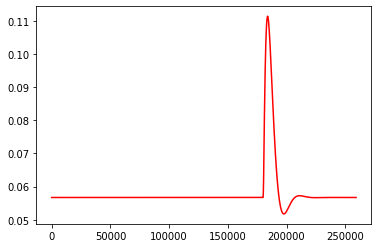

In [10]:
plot(r1['time'],r1['glucoseInsulinRegulation.out2'])

In [ ]:
# Task 2.2 simulate with relative beta to 50% of norm and show results
r2 = simulate_relativebeta(...)
plot(r2['time'],r2['glucoseInsulinRegulation.out2'])

## 3. Glucose tolerance test data

Glucose tolerance test  is a medical test in which glucose is given and blood samples taken afterward to determine how quickly it is cleared from the blood. The test is usually used to test for diabetes, insulin resistance, impaired beta cell function.[Wikipedia][1]

The intravenous glucose tolerance test (GTT) aids in evaluating the time to onset of diabetes among persons expressing anti-islet autoantibodies.[ScienceDirect][2]

[1]: https://en.wikipedia.org/wiki/Glucose_tolerance_test
[2]: https://www.sciencedirect.com/topics/medicine-and-dentistry/intravenous-glucose-tolerance-test


Import the GTT data containing concentration of insulin measured Data were taken for 2 hours every 12 minutes. The intravenous infusion of glucose starts at time 12 minutes (720s) with glucose infusion rate 27.78 mg/s for 12 minutes. 

In [ ]:
import numpy
my_data_raw = numpy.genfromtxt('PatientInsulinConcentration.csv',delimiter=',')


See what is inside

In [ ]:
my_data_raw

First column contains time, second column contains concentration. In order to have the same shape as simulation data we need to delete first row with nan and transpose i.e. have rows instead of columns. see https://docs.scipy.org/doc/numpy/reference/generated/numpy.delete.html

In [ ]:
my_data = numpy.delete(my_data_raw,...,...) # 3.1 delete first row with nan 
my_data = numpy.transpose(my_data) # transpose columns to rows


In [ ]:
my_data

In [ ]:
plot(my_data[...],my_data[...]) # task 3.2 plot time on x axis and insulin conccentration on y axis

## 4. Calibrate model with data 

In order to compare simulation model with data we need to calibrat first the coresponding data.

  * 4.1 find appropriate time interval - recalculate number of simulation steps equally spread among simulation time 3 days
  * 4.2 find corresponding area to compare with data


### Set simulation interval to be equal to experiment interval

In [ ]:
simulation_time = ... # Task 4.1 3 days - model simulation will get into steady state during this time
sample_duration = ... # 12 minutes - to be equal to sample interval of experiment data
number_of_steps = simulation_time // sample_duration;
number_of_steps




In [ ]:
opts["ncp"] = number_of_steps # we set it to simulation options

simulate with options

In [ ]:
r2 = simulate_relativenu(sopts=opts)

In [ ]:
r2['time'].size # see the size of row - number of steps being taken during simulation


If this differs from the desired 360 + 1 initial step - then numerical solver probably stores event points. Disable storing extra event points [more info in jmodelica sources][1]

[1]: https://jmodelica.org/pyfmi/_modules/pyfmi/fmi_algorithm_drivers.html

In [ ]:
opts["CVode_options"]["store_event_points"] = False # by default it is true and 
# CVODE solver will create additional event points during simulation to the requested ncp points
r3 = simulate_relativenu()

In [ ]:
r3['time'].size

Now the step of simulation agrees of experiment.

In [ ]:
r3['time']

### select coresponding simulation part

In [ ]:
# simulation infusion is made sometime at day 2, count index at day 2
index = ... // 720; # task 4.2 // is integer division
index

In [ ]:
# how many samples we need to compare? size of sample data

In [ ]:
sample_size = my_data[0].size
sample_size


see when the infusion is really made

In [ ]:
r3['glucoseInsulinRegulation.in1'][index:index+sample_size]

Thus we need to increase index by 9.

In [ ]:
index2 = index + 9
print(index)
print(r3['glucoseInsulinRegulation.in1'][index2:index2+sample_size])
print(r3['glucoseInsulinRegulation.out2'][index2:index2+sample_size])

In [ ]:
my_data[1]

In [ ]:
print("Number of steps to simulate model calibrated to experiment data:",number_of_steps)
print("Index of simulation data coresponding to experiment data:",index2)
print("Number of samples to be compared:",sample_size)

## 5. Compare data and simulation

We define function `compareshow` which will simulate the model with desired parameter value and creates a chart comparing the insulin concentration from model simulation with experimental data

In [ ]:
def compareshow(relbeta,comp_index=index2,comp_size=sample_size,data=my_data):
    # simulate with parameter 
    res = simulate_relativebeta(...) # task 5.1 which argument to be passed here
    # get the times on the interval to be compared
    times = res['time'][comp_index:comp_index+comp_size]
    # get subset of data on the interval to be compared
    simdata = res['glucoseInsulinRegulation.out2'][comp_index:comp_index+comp_size]
    # set matplotlib to generate inline graphs other options can be 'notebook' etc.
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(times,simdata,'b', label='simulated data for '+str(relbeta))
    plt.plot(times,data[1],'r--', label='experimental data')
    plt.legend(loc='lower right')
    plt.show()
    # task 5.1a - add optional parameter which will simulate in other relbeta values and plot additional chart
    # thus having 3-4 curves in  chart

In [ ]:
compareshow(1)

In [ ]:
#5.2 task try to compare with simulation parameter to 120%, 50%, 20%, 5%, 1% 
compareshow(...)

## 6 Parameter sweep model/experiment comparison

In this secion we will sweep parameter over some range and compute objective function $ y=\sum_{i=1}^n (s_i - d_i)^2 $



In [ ]:
def my_diff(arr1,arr2):
    sum = 0
    for i in range(0,arr1.size):
        sum+=... #task 6.2 - place how to compute difference as per equation above
    return sum
            

Test the implementation of my_diff function with test bellow. The ressult should be 2.

In [ ]:
arr1 = numpy.array([1,1,1,1,1,1,1,1])
arr2 = numpy.array([1,1,1,1,2,1,1,2])
arr3 = my_diff(arr1,arr2)
print(arr3) # should output 2
if (arr3 == 2): 
    print('You can continue')
else:
    print('Wrong implementation of my_diff. Repair it!')

Now we define `sweep_parameter` function which will call simulation with different parameters and sum the difference.

In [ ]:
def sweep_parameter(min,max,step,data=my_data):
    # returns array of tuple - first is parameter value, second is distance from experiment data
    import numpy
    diffs = []
    for x in numpy.arange(min,max,step):
        r = simulate_relativebeta(x)
        rsample = r['glucoseInsulinRegulation.out2'][index2:index2+sample_size]
        sum = my_diff(rsample,data[1])        
        diffs.append([x,sum])
    return diffs

In [ ]:
#task 6.2 do parameter sweep and simulate with different parameters first from 0.5 to 1 with step 0.1

diffs = sweep_parameter(...,...,...)

Now we can see `diffs` array. Contains array of tupple. First is parameter value, second the value of objective function.

In [ ]:
diffs

## Find minimum 
Find parameter value, where objective function is minimal.

E.g. sort the diffs array by the second element

In [ ]:
diffs.sort(key=lambda x:x[1])

In [ ]:
diffs

Now the first element of diffs contains parameter and value of objective function which is minimal.

Show the model simulation and data in chart:

In [ ]:
compareshow(...) # task 6.3

In [ ]:
compareshow(...) # task 6.4 show second best solution

# Summary

In the above excercise we
  * imported Pyfmi library and load FMU of the Modelica model
  * simulated the model with different parameters and plot the simulation result
  * read and plot experiment data from csv
  * calibrate the model - find simulation parameters - number of intervals and index of result file corresponding to the experiment data
  * compared experiment data with simulation data
  * do parameter sweep - simulation performed per each parameter value
  * compute difference between experimental data and simulation data - value of objective function
  * minimum of objective function corresponds to optimal parameter value based on experimental data
  * this process is sometimes called also matching the curve, parameter estimation, system identification
  * solution to tasks within the python code is in comments bellow
  
  * Last but not least - you learn something about glucose insulin regulation and type1 diabetes
  

In [ ]:
#2.1 259200    res = model.simulate(final_time=259200,options = sopts)
#2.2 r2 = simulate_relativebeta(0.5)
#3.1 numpy.delete(array,0,0)
#3.2 plot(my_data[0],my_data[1]) 
#4.1 simulation_time = 3 * 24 * 60 * 60
#    sample_duration = 12 * 60 
#4.2 index = 2*24*60*60 // 720; # task 4.2
#5.1 res = simulate_relativebeta(relbeta) # task 5.1 which argument to be passed here
#5.2 task try to compare with simulation parameter to 120%, 50%, 20%, 5%, 1% 
#compareshow(1.2)
#compareshow(0.5)
#compareshow(0.2)
#compareshow(0.05)
#compareshow(0.01)
#6.1 sum+=(arr1[i]-arr2[i])**2
#6.2 diffs = sweep_parameter(0.5,1,0.1)
#6.3 compareshow(diffs[0][0]) 
